## The mysterious yet powerful XGBoost model 

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import os
import xgboost as xgb
## label encoding
import sklearn
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

SUBSET = True

DIR_PATH = '../../data/'

In [104]:
## loading data as Pandas dataframes
train_raw = pd.read_csv(os.path.join(DIR_PATH, 'train_total.csv'), 
                        header='infer', 
                        index_col='id',
                        parse_dates=['timestamp'])
test_raw = pd.read_csv(os.path.join(DIR_PATH, 'test_total.csv'), 
                       header='infer', 
                       index_col='id',
                       parse_dates=['timestamp'])

"""
macro = pd.read_csv(os.path.join(DIR_PATH, 'macro.csv'), 
                    header='infer')
"""

"\nmacro = pd.read_csv(os.path.join(DIR_PATH, 'macro.csv'), \n                    header='infer')\n"

#### Some minor feature extraction

In [105]:
## log transformation
#train_raw.loc[:, 'log_price_doc'] = np.log(train_raw['price_doc'] + 1)

## time features
train_raw.loc[:, 'year'] = train_raw.loc[:, 'timestamp'].apply(lambda x: x.strftime('%Y'))
train_raw.loc[:, 'month'] = train_raw.loc[:, 'timestamp'].apply(lambda x: x.strftime('%m'))

test_raw.loc[:, 'year'] = test_raw.loc[:, 'timestamp'].apply(lambda x: x.strftime('%Y'))
test_raw.loc[:, 'month'] = test_raw.loc[:, 'timestamp'].apply(lambda x: x.strftime('%m'))

### Choose the desired slice of data for the model

Pick either a subset of features or use the entire dataset

In [107]:
if SUBSET:  
    features = ['year', 'month', 'full_sq', 'life_sq', 'floor', 
                    'max_floor', 'material', 'build_year', 'num_room',
                    'kitch_sq', 'state', 'radiation_km', 'basketball_km']
    train = train_raw[features]
    test = test_raw[features]
else:
    train = train_raw.copy()
    test = train_raw.copy()
    features = list(test.columns)

#### Remove certain columns from the data 

In [108]:
if 'timestamp' in features:
    train.drop('timestamp', inplace = True, axis = 1)
    test.drop('timestamp', inplace = True, axis = 1)
    features.remove('timestamp')

#### Must encode object type columns so that they can be handled by the model. This is something that R does automatically.

In [109]:
for f in train.columns:
    if train[f].dtype=='object':
        print('encoding feature: {}'.format(f))
        lbl = sklearn.preprocessing.LabelEncoder()
        lbl.fit(list(train[f].values)) 
        train[f] = lbl.transform(list(train[f].values))

encoding feature: year
encoding feature: month


/home/mes/venv/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [110]:
# Convert to numpy values

X_train = train.values

# price or log(price)?
Y_train = train_raw['price_doc'].values
#Y_train = train_raw['log_price_doc'].values

X_test = test.values

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)

(30471, 13)
(30471,)
(7662, 13)


In [112]:
size_ = 7000
X_train_sub, Y_train_sub = X_train[:-size_],  Y_train[:-size_]
X_val, Y_val = X_train[-size_:],  Y_train[-size_:]

In [113]:
# Create a validation set, with last 20% of data
dtrain = xgb.DMatrix(X_train, 
                    Y_train, 
                    feature_names=features)
dtrain_sub = xgb.DMatrix(X_train_sub, 
                        Y_train_sub, 
                        feature_names=features)
d_val = xgb.DMatrix(X_val, 
                    Y_val, 
                    feature_names=features)
dtest = xgb.DMatrix(X_test, 
                    feature_names=features)

In [114]:
# hyperparameters
xgb_params = {
    'eta': 0.02,
    'max_depth': 5,
    'subsample': .8,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

# Uncomment to tune XGB `num_boost_rounds`
sub_model = xgb.train(xgb_params, 
                      dtrain_sub, 
                      num_boost_round=2000,
                      evals=[(d_val, 'val')],
                      early_stopping_rounds=20, 
                      verbose_eval=20)

[0]	val-rmse:9.30914e+06
Will train until val-rmse hasn't improved in 20 rounds.
[20]	val-rmse:6.94916e+06
[40]	val-rmse:5.48031e+06
[60]	val-rmse:4.582e+06
[80]	val-rmse:4.04005e+06
[100]	val-rmse:3.71493e+06
[120]	val-rmse:3.51002e+06
[140]	val-rmse:3.38423e+06
[160]	val-rmse:3.29841e+06
[180]	val-rmse:3.22991e+06
[200]	val-rmse:3.18814e+06
[220]	val-rmse:3.15564e+06
[240]	val-rmse:3.12731e+06
[260]	val-rmse:3.10072e+06
[280]	val-rmse:3.08494e+06
[300]	val-rmse:3.07277e+06
[320]	val-rmse:3.06382e+06
[340]	val-rmse:3.05089e+06
[360]	val-rmse:3.04077e+06
[380]	val-rmse:3.02759e+06
[400]	val-rmse:3.01921e+06
[420]	val-rmse:3.00895e+06
[440]	val-rmse:3.00108e+06
[460]	val-rmse:2.99539e+06
[480]	val-rmse:2.99161e+06
[500]	val-rmse:2.98616e+06
[520]	val-rmse:2.98205e+06
[540]	val-rmse:2.9757e+06
[560]	val-rmse:2.9715e+06
[580]	val-rmse:2.96612e+06
[600]	val-rmse:2.9612e+06
[620]	val-rmse:2.95864e+06
[640]	val-rmse:2.9531e+06
[660]	val-rmse:2.94875e+06
[680]	val-rmse:2.94568e+06
[700]	val-r

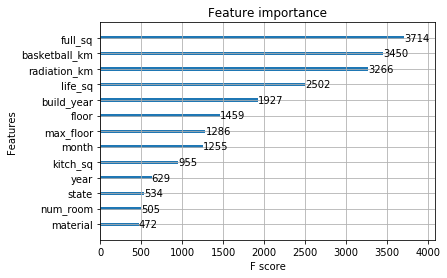

In [115]:
xgb.plot_importance(sub_model)

In [116]:
full_model = xgb.train(xgb_params,
                       dtrain, 
                       num_boost_round=sub_model.best_iteration,
                       verbose_eval=20)

In [117]:
#log_y_pred = full_model.predict(dtest)
#y_pred = np.exp(log_y_pred) - 1
y_pred = full_model.predict(dtest)

In [118]:
submit = pd.DataFrame({'id': np.array(test.index), 'price_doc': y_pred})
submit.to_csv('submission_xgb2.csv', index=False)